In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
import climlab
from climlab import constants as const


## Vertical structure of CO2-driven warming in CESM

Here we are going to look at the vertical structure of the warming in the CO2-driven CESM cases that we've already started to analyze.

In [2]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
# basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'

In [3]:
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [4]:
# extract the last 10 years from the slab ocean control simulation
# and the last 20 years from the coupled control
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

In [5]:
# Extract some air temperature fields and do some time- and spatial- averaging
air_temperature = {}
air_temperature_global = {}
air_temperature_zonal = {}
air_temperature_tropical = {}

tropics = slice(-30,30)
gw = atm['som_control'].gw

for name in casenames:
    if 'som' in name:
        thisslice = clim_slice_slab
    else:
        thisslice = clim_slice_cpl
    air_temperature[name] = atm[name].T.isel(time=thisslice).mean(dim='time')
    air_temperature_zonal[name] = air_temperature[name].mean(dim='lon')
    air_temperature_global[name] = air_temperature[name].weighted(gw).mean(dim=('lat','lon'))
    air_temperature_tropical[name] = air_temperature[name].sel(lat=tropics).weighted(gw.sel(lat=tropics)).mean(dim=('lat','lon'))

Text(0.5, 0.98, 'Vertical structure of CO2-driven warming in the CESM')

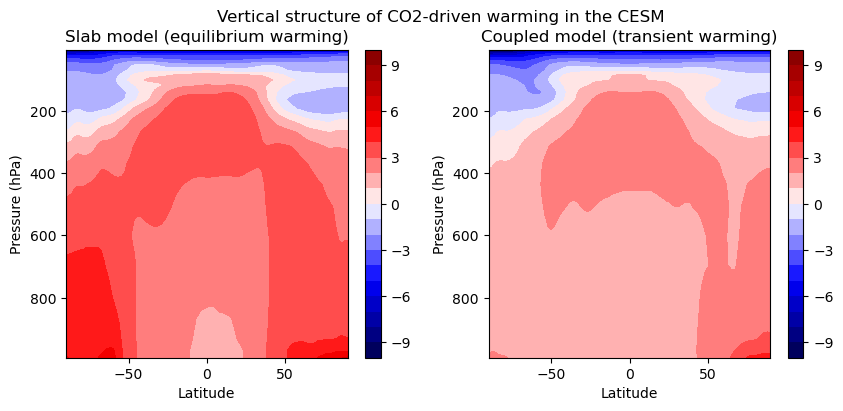

In [6]:
# Plot the zonal average warming as a function of latitude and pressure
lev_cesm = atm['som_control'].lev
lat_cesm = atm['som_control'].lat

fig, axes = plt.subplots(1,2, figsize=(10,4))

ax = axes[0]
mesh = ax.contourf(lat_cesm, lev_cesm,
    air_temperature_zonal['som_2xCO2'] - air_temperature_zonal['som_control'],
             cmap='seismic', levels=np.linspace(-10,10,21))
fig.colorbar(mesh, ax=ax)
ax.set_title('Slab model (equilibrium warming)')

ax = axes[1]
mesn = ax.contourf(lat_cesm, lev_cesm,
    air_temperature_zonal['cpl_CO2ramp'] - air_temperature_zonal['cpl_control'],
             cmap='seismic', levels=np.linspace(-10,10,21))
fig.colorbar(mesh, ax=ax)
ax.set_title('Coupled model (transient warming)')

for ax in axes:
    ax.invert_yaxis()
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Pressure (hPa)')

fig.suptitle('Vertical structure of CO2-driven warming in the CESM')

Features here include the upper-tropospheric warming maximum in the tropics, and polar amplified warming that peaks at the surface.

Key differences between the equilibrium and transient case include:

- Equilibrium case exhibits greater warming
- Equilibrium case exhbits roughly symmetric warming between the two hemispheres. The transient case instead shows strongly *Arctic-amplified* warming in the NH.

### Vertical structure of tropical warming on a Skew-T plot

Text(0, 0.5, 'Pressure (hPa)')

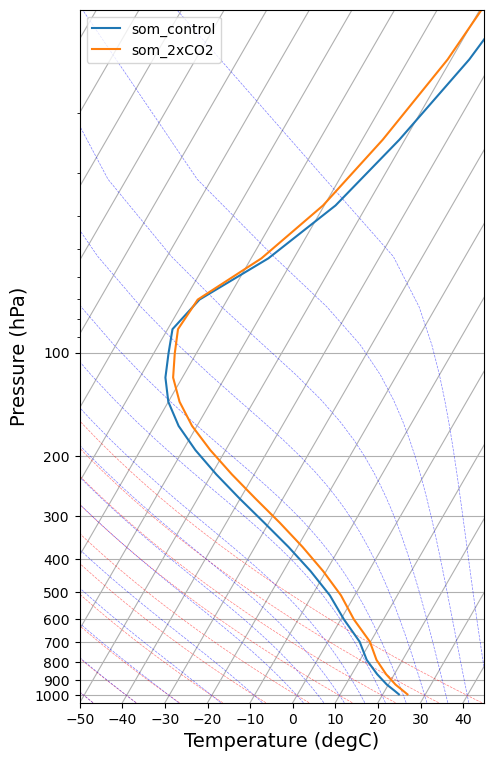

In [7]:
fig = plt.figure(figsize=(9,9))

skew = SkewT(fig, rotation=30)
for name in ['som_control', 'som_2xCO2']:
    skew.plot(lev_cesm, air_temperature_tropical[name] - const.tempCtoK,
             label=name)
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-50, 45)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)
#skew.plot_mixing_lines()
skew.ax.legend()
skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)

This comparison shows how the tropical lapse rates tend to stay close to the moist adiabat.

Notice that the temperature difference between adjacent moist adiabatcs is *larger* at *lower pressure* (or higher elevation). This helps explain the upper-tropospheric warming maximum that we noticed above.

### Tropical temperature differences

Let's plot the air temperature change averaged over the tropics. 

Here's we'll use a pressure axis rather than log-pressure.

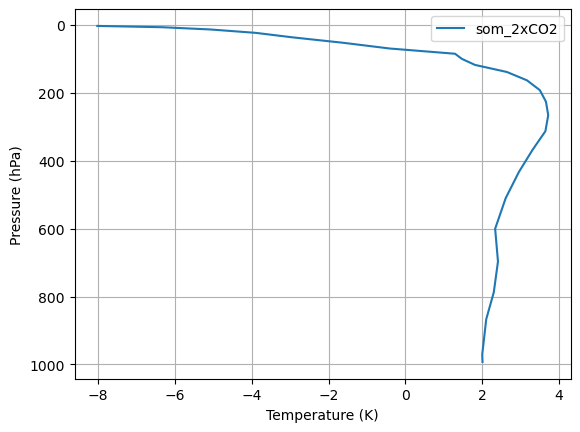

In [8]:
fig,ax = plt.subplots()
    
ax.plot(air_temperature_tropical['som_2xCO2'] - air_temperature_tropical['som_control'], lev_cesm, label=name)
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.grid()
ax.legend()

This plot highlights the warming maximum at 250 hPa (as well as the stratospheric cooling).

## Exploring the CO2 response in a single-column Radiative Convective Model

Here we are going to set up a slightly more sophisticated Radiative-Convective Model than we've used before.

Instead of presribing the specific humidity profile from observations, we will follow classic work by Manabe and Wetherald (1967) and specify the **relative humidity profile**.

This means that the specific humidity (absolute amount of water vapor) will increase as the climate warms in response to increased CO$_2$. Therefore our model will include a water vapor feedback.

In [9]:
state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)

## Create individual physical process models:
h2o = climlab.radiation.ManabeWaterVapor(name='H2O', state=state)
convadj = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                  state=state,
                                                  adj_lapse_rate='pseudoadiabat')
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state,
                              specific_humidity=h2o.q,
                              albedo = 0.19,
                             )
rcm = climlab.couple([rad,convadj,h2o], name='RCM')

print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (40,) 
The subprocess tree: 
RCM: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [10]:
rcm.integrate_years(10)

Integrating for 3652 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 9.998844602294039 years.


In [11]:
rcm.ASR - rcm.OLR

Field([7.36059235e-05])

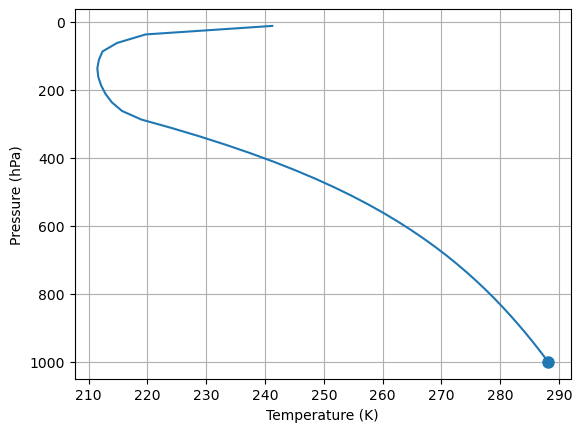

In [12]:
fig, ax = plt.subplots()
line = ax.plot(rcm.Tatm, rcm.lev)[0]
ax.plot(rcm.Ts, 1000., 'o', markersize=8, color=line.get_color(), label='RCM control')
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.grid()

In [13]:
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
rcm_2xCO2.integrate_years(10.)

Integrating for 3652 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 19.997689204588077 years.


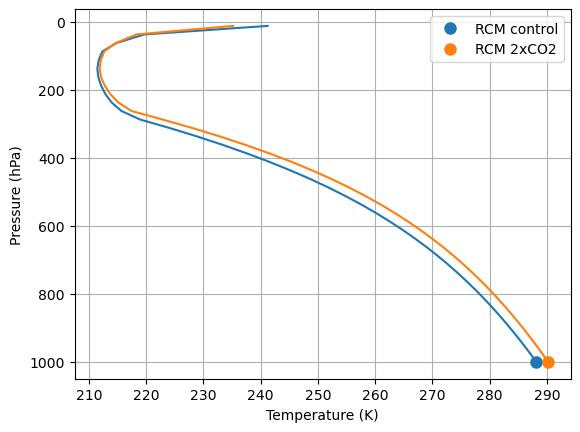

In [14]:
line = ax.plot(rcm_2xCO2.Tatm, rcm_2xCO2.lev)[0]
ax.plot(rcm_2xCO2.Ts, 1000., 'o', markersize=8, color=line.get_color(), label='RCM 2xCO2')
ax.legend()
fig

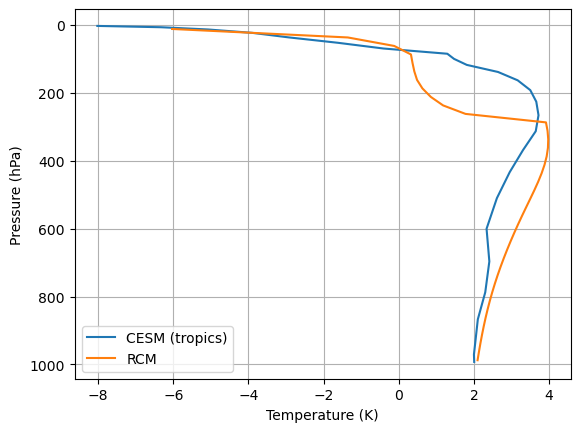

In [15]:
fig,ax = plt.subplots()
    
ax.plot(air_temperature_tropical['som_2xCO2'] - air_temperature_tropical['som_control'], lev_cesm, label='CESM (tropics)')
ax.plot(rcm_2xCO2.Tatm - rcm.Tatm, rcm.lev, label='RCM')
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.grid()
ax.legend()

### What the Equilibrium Climate Sensitivity (ECS) of this model?

In [16]:
ecs = (rcm_2xCO2.Ts - rcm.Ts)[0]
print(f'The ECS of the RCM with moist adiabatic lapse rate is {ecs:.2f} K.')

The ECS of the RCM with moist adiabatic lapse rate is 2.08 K.


### What happens if the lapse rate is fixed instead?

In [17]:
state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)

## Create individual physical process models:
h2o = climlab.radiation.ManabeWaterVapor(name='H2O', state=state)
convadj = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                  state=state,
                                                  adj_lapse_rate=6.5)
# coszen = np.cos(np.deg2rad(75))
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state,
                              specific_humidity=h2o.q,
                              # coszen=coszen,
                              # irradiance_factor=0.25/coszen,
                              albedo = 0.19,
                             )

rcm_nolapse = climlab.couple([rad,convadj,h2o], name='RCM')

rcm_nolapse.integrate_years(10)

rcm_nolapse_2xCO2 = climlab.process_like(rcm_nolapse)
rcm_nolapse_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
rcm_nolapse_2xCO2.integrate_years(10.)

Integrating for 3652 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 9.998844602294039 years.
Integrating for 3652 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 19.997689204588077 years.


The ECS of the fixed-lapse-rate RCM is 2.38 K


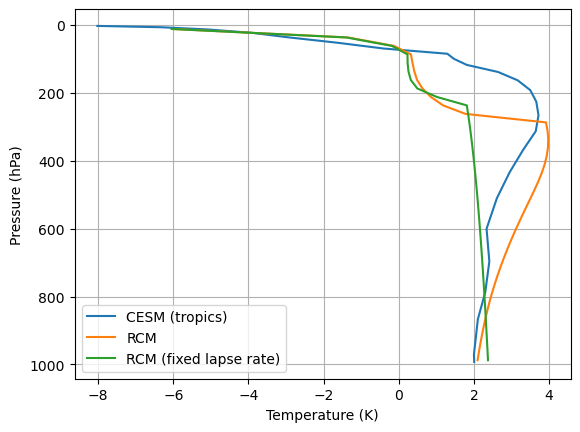

In [18]:
fig,ax = plt.subplots()
ax.plot(air_temperature_tropical['som_2xCO2'] - air_temperature_tropical['som_control'], lev_cesm, label='CESM (tropics)')
ax.plot(rcm_2xCO2.Tatm - rcm.Tatm, rcm.lev, label='RCM')
ax.plot(rcm_nolapse_2xCO2.Tatm - rcm_nolapse.Tatm, rcm.lev, label='RCM (fixed lapse rate)')
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.grid()
ax.legend()

ecs_nolapse = (rcm_nolapse_2xCO2.Ts - rcm_nolapse.Ts)[0]
print(f'The ECS of the fixed-lapse-rate RCM is {ecs_nolapse:.2f} K')

## Lapse rate feedback

Discuss the notion of a "Lapse rate feedback" and interpret this result.

Draw sketches of the column response to an increase in the average level of emission when we double CO$_2$.